### Connecting Google Colab with your Google Drive

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Text Classification

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* Text Classification is an automated process of classification of text into pre-defined categories. We can classify emails into spam or non-spam, news articles into different categories like Politics, Technology, Sports, etc.

In [ ]:
from IPython.display import Image
Image("/content/gdrive/MyDrive/img/img/text_img.png")

#### Loading required libraries

In [4]:
import pandas as pd
import numpy as np

import spacy
nlp = spacy.load('en_core_web_sm')

from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes, svm
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

#### SMS Spam Collection Dataset

__Context:__

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,572 messages, tagged as "ham" (legitimate) or "spam".

__Content:__

The file 'SMSSpamCollection.csv' contains one message per line. Each line is composed of two columns: column1 contains the label (ham or spam) and column2 contains the raw text.

In [5]:
pd.set_option('display.max_colwidth', 300)

#### Reading the dataset

In [6]:
corpus = pd.read_csv("/content/drive/MyDrive/SMSSpamCollection.unknown",sep = '\t',header = None)

In [7]:
corpus.head()

0  \
0   ham   
1   ham   
2  spam   
3   ham   
4   ham   

                                                                                                                                                             1  
0                                              Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...  
1                                                                                                                                Ok lar... Joking wif u oni...  
2  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's  
3                                                                                                            U dun say so early hor... U c already then say...  
4                                                                                                Nah I don't think he goes to usf, he lives around here though

#### Understand and analyse data

Check the number of rows and columns

In [8]:
corpus.shape

(5572, 2)

#### Display top 5 rows

In [9]:
corpus.head(5)

0  \
0   ham   
1   ham   
2  spam   
3   ham   
4   ham   

                                                                                                                                                             1  
0                                              Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...  
1                                                                                                                                Ok lar... Joking wif u oni...  
2  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's  
3                                                                                                            U dun say so early hor... U c already then say...  
4                                                                                                Nah I don't think he goes to usf, he lives around here though

Change column names from 0 and 1 to 'type' and 'text' respectively

In [10]:
# Change Column names
corpus.rename(columns = {0:'type',1:'text'},inplace = True)

Display top 5 rows

In [11]:
corpus.head()

type  \
0   ham   
1   ham   
2  spam   
3   ham   
4   ham   

                                                                                                                                                          text  
0                                              Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...  
1                                                                                                                                Ok lar... Joking wif u oni...  
2  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's  
3                                                                                                            U dun say so early hor... U c already then say...  
4                                                                                                Nah I don't think he goes to usf, he lives around here though

#### Distribution of data w.r.t type

In [12]:
print(corpus.groupby("type").count())
print(corpus["type"].value_counts())

      text
type      
ham   4825
spam   747
ham     4825
spam     747
Name: type, dtype: int64


% distribution of data w.r.t type

In [13]:
corpus["type"].value_counts(normalize = True)*100

ham     86.593683
spam    13.406317
Name: type, dtype: float64

#### Checking for Null values

In [14]:
corpus.isna().mean()

type    0.0
text    0.0
dtype: float64

In [15]:
corpus.isna().sum()

type    0
text    0
dtype: int64

#### Observation: There are no Null values in the dataset

### Text Pre-processing

In [16]:
# Step - a: Remove blank rows if any
# corpus['text'].dropna(inplace=True) 

# Step - b: Change all the text to lower case. This is required as python interprets 'data' and 'DATA' differently
corpus['text'] = [sentence.lower() for sentence in corpus['text']]

# Step - c: Tokenization and Remove Stop words, Numeric and perfom Word Lemmatization.
stop_words = list(STOP_WORDS)
for index, entry in enumerate(corpus['text']):
    tokens = [token.lemma_ for token in nlp(entry) if ((str(token) not in stop_words) and (token.is_alpha == True))]
    clean_text = " ".join(tokens)
    corpus.loc[index,'clean_text'] = clean_text

In [17]:
# Example of enumerate
for index, entry in enumerate(["A","B","C","D"]):
    print (index, entry)

0 A
1 B
2 C
3 D


#### Display top 5 rows after Text Pre-processing

In [18]:
corpus.head()

type  \
0   ham   
1   ham   
2  spam   
3   ham   
4   ham   

                                                                                                                                                          text  \
0                                              go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...   
1                                                                                                                                ok lar... joking wif u oni...   
2  free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question(std txt rate)t&c's apply 08452810075over18's   
3                                                                                                            u dun say so early hor... u c already then say...   
4                                                                                                nah i don't think he goes to usf, he lives around here though   

                                                                        clean_text  
0  jurong point crazy available bugis n great world la e buffet cine get amore wat  
1                                                            ok lar joke wif u oni  
2       free entry wkly comp win fa cup final tkts text fa receive entry txt apply  
3                                                              u dun early hor u c  
4                                                            nah think go usf live

In [19]:
# remove short words (length < 2)
corpus['meaningful_text'] = corpus['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))

In [20]:
corpus.head()

type  \
0   ham   
1   ham   
2  spam   
3   ham   
4   ham   

                                                                                                                                                          text  \
0                                              go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...   
1                                                                                                                                ok lar... joking wif u oni...   
2  free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question(std txt rate)t&c's apply 08452810075over18's   
3                                                                                                            u dun say so early hor... u c already then say...   
4                                                                                                nah i don't think he goes to usf, he lives around here though   

                                                                        clean_text  \
0  jurong point crazy available bugis n great world la e buffet cine get amore wat   
1                                                            ok lar joke wif u oni   
2       free entry wkly comp win fa cup final tkts text fa receive entry txt apply   
3                                                              u dun early hor u c   
4                                                            nah think go usf live   

                                                               meaningful_text  
0  jurong point crazy available bugis great world la buffet cine get amore wat  
1                                                          ok lar joke wif oni  
2   free entry wkly comp win fa cup final tkts text fa receive entry txt apply  
3                                                                dun early hor  
4                                                        nah think go usf live

In [21]:
corpus.dtypes

type               object
text               object
clean_text         object
meaningful_text    object
dtype: object

In [22]:
# Convert the 'type' column to appropriate datatype
corpus['type'] = corpus['type'].astype("category")

In [23]:
corpus.dtypes

type               category
text                 object
clean_text           object
meaningful_text      object
dtype: object

### Visualizing most frequent words using WordCloud

```Python
!pip install wordcloud
  (or)
!conda install -c conda-forge wordcloud=1.6.0
```

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [25]:
spam_messages = corpus[corpus["type"] == "spam"]["meaningful_text"]
ham_messages = corpus[corpus["type"] == "ham"]["meaningful_text"]

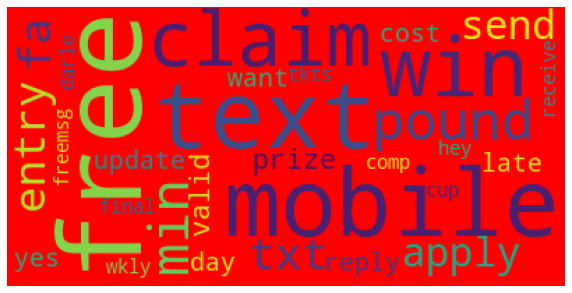

In [26]:
wordcloud = WordCloud(max_font_size=80,max_words=30, background_color="red").generate(str(spam_messages))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

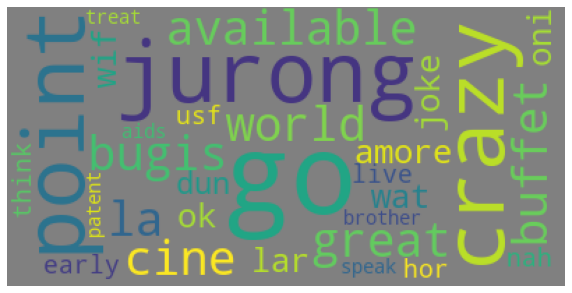

In [27]:
wordcloud = WordCloud(max_font_size=80,max_words=30, background_color="gray").generate(str(ham_messages))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Perform the train test split on the data and then build the model

In [28]:
train_X, test_X, train_y, test_y = train_test_split(corpus['meaningful_text'], corpus['type'], 
                                                    stratify = corpus['type'],
                                                    test_size=0.3, random_state=123)


In [29]:
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(3900,)
(1672,)
(3900,)
(1672,)


In [42]:
train_X.head()


4897                                                                           half year miss
376                                                                                    happen
2896                                                                     go ganesh dress shop
3472    heart love mind wisdom eye dream amp life frnd alwys touch good night amp sweet dream
2264           hear rude chat private line cum wan pic gettin shag text pix send stop sam xxx
Name: meaningful_text, dtype: object

In [49]:
train_y.value_counts(normalize=True)*100

ham     86.589744
spam    13.410256
Name: type, dtype: float64

In [50]:
test_y.value_counts(normalize=True)*100

ham     86.602871
spam    13.397129
Name: type, dtype: float64

In [31]:
train_y.head()

4897     ham
376      ham
2896     ham
3472     ham
2264    spam
Name: type, dtype: category
Categories (2, object): ['ham', 'spam']

In [32]:
test_X.head()

4620                                                                   sorry later meeting
573                                                                              open door
1591        somewhr surely god decide perfect time meet dat person till den enjoy ur crush
1236    opinion jada kusruthi lovable silent spl character mature stylish simple pls reply
4819                                                                              ur paper
Name: meaningful_text, dtype: object

In [33]:
test_y.head()

4620    ham
573     ham
1591    ham
1236    ham
4819    ham
Name: type, dtype: category
Categories (2, object): ['ham', 'spam']

### Calculate TF-TDF
####  Term Frequency: This summarizes how often a given word appears within a document
#### Inverse Document Frequency: This down scales words that appear a lot across documents

In [34]:
# Extending stop words list
stop_words = list(stop_words) + ['aa','aah','da','lar','ok']

Tfidf_vect = TfidfVectorizer(stop_words=stop_words, max_df=0.8)

Tfidf_vect.fit(train_X)

train_X_Tfidf = Tfidf_vect.transform(train_X)
test_X_Tfidf = Tfidf_vect.transform(test_X)

In [35]:
print(train_X_Tfidf.shape)

(3900, 5032)


In [58]:
print(train_X_Tfidf[0])
print(train_X_Tfidf[:1])

  (0, 1825)	0.6306275932707028
  (0, 2717)	0.5335939210290623
  (0, 4983)	0.5635480157417216
  (0, 1825)	0.6306275932707028
  (0, 2717)	0.5335939210290623
  (0, 4983)	0.5635480157417216


In [37]:
# Coverting to dense matrix and putting in a dataframe to view the Tfidf matrix
dense_mat = train_X_Tfidf.todense()
tfidf_Mat = pd.DataFrame(dense_mat, columns=Tfidf_vect.get_feature_names_out())
tfidf_Mat.head()

aaooooright  aathi   ab  abbey  abeg  abel  aberdeen  abi  ability  abiola  \
0          0.0    0.0  0.0    0.0   0.0   0.0       0.0  0.0      0.0     0.0   
1          0.0    0.0  0.0    0.0   0.0   0.0       0.0  0.0      0.0     0.0   
2          0.0    0.0  0.0    0.0   0.0   0.0       0.0  0.0      0.0     0.0   
3          0.0    0.0  0.0    0.0   0.0   0.0       0.0  0.0      0.0     0.0   
4          0.0    0.0  0.0    0.0   0.0   0.0       0.0  0.0      0.0     0.0   

   ...  zealand  zebra  zero  zhong  zindgi  zoe  zogtorius  zoom  zouk  zyada  
0  ...      0.0    0.0   0.0    0.0     0.0  0.0        0.0   0.0   0.0    0.0  
1  ...      0.0    0.0   0.0    0.0     0.0  0.0        0.0   0.0   0.0    0.0  
2  ...      0.0    0.0   0.0    0.0     0.0  0.0        0.0   0.0   0.0    0.0  
3  ...      0.0    0.0   0.0    0.0     0.0  0.0        0.0   0.0   0.0    0.0  
4  ...      0.0    0.0   0.0    0.0     0.0  0.0        0.0   0.0   0.0    0.0  

[5 rows x 5032 columns]

In [38]:
print([col for col in tfidf_Mat.columns])

['aaooooright', 'aathi', 'ab', 'abbey', 'abeg', 'abel', 'aberdeen', 'abi', 'ability', 'abiola', 'abj', 'able', 'abnormally', 'abouta', 'absolutly', 'abstract', 'abt', 'abta', 'aburo', 'abuse', 'abuser', 'ac', 'academic', 'acc', 'accent', 'accenture', 'accept', 'access', 'accessible', 'accidant', 'accident', 'accidentally', 'accommodation', 'accommodationvoucher', 'accomodate', 'accomodation', 'accordingly', 'account', 'accumulation', 'achan', 'ache', 'achieve', 'acnt', 'act', 'action', 'activate', 'active', 'activity', 'actor', 'actual', 'actually', 'ad', 'adam', 'add', 'addamsfa', 'addict', 'addie', 'address', 'adewale', 'adi', 'adjustable', 'admin', 'admirer', 'admission', 'admit', 'adore', 'adrian', 'adult', 'advance', 'adventure', 'advice', 'advise', 'affair', 'affection', 'affectionate', 'affidavit', 'afghanistan', 'afraid', 'african', 'aft', 'afternon', 'afternoon', 'aftr', 'ag', 'agalla', 'age', 'agency', 'agidhane', 'ago', 'agree', 'ah', 'aha', 'ahead', 'ahhh', 'ahhhh', 'ahmad'

#### Use the ML Algorithms to Predict the label

#### Naive Bayes

In [39]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(train_X_Tfidf, train_y)

# predict the labels on train dataset
pred_train = Naive.predict(train_X_Tfidf)

# predict the labels on validation dataset
pred_test = Naive.predict(test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score on Train set      -> ", accuracy_score(train_y, pred_train)*100)
print("Naive Bayes Accuracy Score on Validation set -> ", accuracy_score(test_y, pred_test)*100)
print("Naive Bayes Recall Score on Validation set   -> ", recall_score(test_y, pred_test, pos_label='spam')*100)
print("Naive Bayes Precision Score on Validation set-> ", precision_score(test_y, pred_test, pos_label='spam')*100)

Naive Bayes Accuracy Score on Train set      ->  97.0
Naive Bayes Accuracy Score on Validation set ->  96.65071770334929
Naive Bayes Recall Score on Validation set   ->  75.0
Naive Bayes Precision Score on Validation set->  100.0


#### SVM

In [40]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(kernel='linear')
SVM.fit(train_X_Tfidf,train_y)

# predict the labels on train dataset
pred_train1 = SVM.predict(train_X_Tfidf)

# predict the labels on validation dataset
pred_test1 = SVM.predict(test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score on Train set.     -> ", accuracy_score(train_y, pred_train1)*100)
print("SVM Accuracy Score on Validation set -> ", accuracy_score(test_y, pred_test1)*100)
print("SVM Recall Score on Validation set.  -> ", recall_score(test_y, pred_test1, pos_label='spam')*100)
print("SVM Precision Score on Validation set-> ", precision_score(test_y, pred_test1, pos_label='spam')*100)

SVM Accuracy Score on Train set.     ->  99.2051282051282
SVM Accuracy Score on Validation set ->  98.20574162679426
SVM Recall Score on Validation set.  ->  88.83928571428571
SVM Precision Score on Validation set->  97.54901960784314


__Observation__: 

    Recall is the performance metric in this case. 
    Based on the Recall score, SVM performed better than Naive Bayes